Goal: measure how correlated certain features of the policy $\pi_0$ are to the value $P(URS | \pi=\pi_0)$, where $URS$ indicates that the policy was optimized for a random reward function $R \in U[-1,1]^{|T|}$ (where $|T|$ is the number of transitions with non-zero probability). For simplicity's sake, we assume that it was either optimized for some $R$ or generated uniformly randomly from the set of all policies, with a 50% chance of each scenario. We also assume that the reward is generated i.i.d. via $R(s, a, s') \sim N(0, 1)$.

In [72]:
import mdptoolbox as mdpt, numpy as np
import mdptoolbox.example

In [158]:
### Generate a bunch of MDPs with different parameters, sparsity
from functools import partial

NUM_MDPs = 100
NUM_STATES = 10
NUM_ACTIONS = 4

def get_transition_matrix(num_states, num_actions, generator = np.random.dirichlet, **kwargs):
    """
    Returns a determinstic transition matrix for a given number of states and actions
    
    Returns:
        P: (num_actions, num_states, num_states) array, where P[a, s, s'] is the probability of 
        transitioning from state s to state s' given action a
    """
    P = np.zeros((num_actions, num_states, num_states)) # (A, S, S) shape
    for a in range(num_actions):
        for s in range(num_states):
            P[a, s, :] = generator(np.ones(num_states))
    return P

def get_reward_matrix(num_states, num_actions, sparsity = 0.0, generator = partial(np.random.uniform, -1, 1), **kwargs):
    """
    Returns a reward matrix for a given number of states and actions
    """
    num_sparse_rewards = int(sparsity * num_actions * num_states ** 2)
    rewards = np.array([(0 if i < num_sparse_rewards else generator(**kwargs)) for i in range(num_actions * num_states ** 2)])
    np.random.shuffle(rewards)
    return rewards.reshape((num_actions, num_states, num_states))

DISCOUNT = 0.9
EPSILON = 0.01 # roughly indicates the "skill level" of the agent
MAX_ITER = 1000

In [159]:
def generate_tests(num_mdps = NUM_MDPs, sparsity_levels: np.ndarray = None, mdp_generator = mdpt.mdp.ValueIteration, P_generator = None, **kwargs):
    """
    Generate a bunch of MDPs with different sparsity levels, and return the sparsity levels and the MDPs

    Args:
        sparsity_levels: a list of sparsity levels to generate MDPs with
    Returns:
        sparsity_levels: the sparsity levels used to generate the MDPs, in the same order as the MDPs
        MDPS: an array of MDPs
    """
    (max_iter, epsilon) = (kwargs['max_iter'], kwargs['epsilon']) if 'max_iter' in kwargs and 'epsilon' in kwargs else (MAX_ITER, EPSILON)
    sparsity_levels = sparsity_levels if sparsity_levels is not None else np.arange(num_mdps) / num_mdps
    sparsity_copy = sparsity_levels.copy() # defensive copy
    np.random.shuffle(sparsity_copy)
    MDPS = np.array([mdp_generator(
        get_transition_matrix(NUM_STATES, NUM_ACTIONS, **kwargs) if P_generator is None else P_generator(NUM_STATES, NUM_ACTIONS, **kwargs), 
        get_reward_matrix(NUM_STATES, NUM_ACTIONS, sparsity_copy[i]), 
        DISCOUNT, max_iter = max_iter) 
        for i in range(num_mdps)
    ])
    for mdp in MDPS:
        if mdp_generator == mdpt.mdp.ValueIteration:
            mdp.epsilon = epsilon
    return sparsity_copy, MDPS

We build a transition function with various settings for properties (e.g. deterministic, sparse, fixed) and train a classifier to predict URS | $\pi = \pi_0$ (baseline probability = 0.5).

In [160]:
### Generate a bunch of MDPs (with baseline/zero sparsity), solve some of them, 
# generate random policy for others

def transition_function_sparse_loops(states, actions, fixed = False, **kwargs):
    """
    Sparse transition function with guaranteed loops
    TODO: possibly implement terminal states
    """
    # print(fixed)
    rng = np.random.default_rng(seed = 0) if fixed else None
    transitions = np.zeros((actions, states, states))
    for state in range(states):
        for action in range(actions):
            if action == 0:
                for next_state in range(states):
                    transitions[action, state, next_state] = 1 if next_state == state else 0
            else: # sparse randomness
                transitions[action, state, :] = np.zeros(states)
                transitions[action, state, np.random.randint(states) if not fixed else rng.integers(0, states)] = 1
    return transitions

NUM_MDPs = 10000
fixed = True
MDPS = generate_tests(NUM_MDPs, sparsity_levels = np.zeros(NUM_MDPs), 
                      P_generator = transition_function_sparse_loops, fixed = fixed)[1]
random_pol_indices = np.random.choice(NUM_MDPs, int(NUM_MDPs / 2), replace = False) # The indices of the MDPs with random policies

In [161]:
# print(random_pol_indices)
for i in range(NUM_MDPs): # 50% RR, 50% random
    MDPS[i].run()
for i in random_pol_indices:
    MDPS[i].policy = np.random.randint(NUM_ACTIONS, size = NUM_STATES)
policies = np.array([mdp.policy for mdp in MDPS])
# print(policies.shape)
random_pol_set = set(random_pol_indices)
random_or_rr = np.array([0 if i in random_pol_set else 1 for i in range(NUM_MDPs)])
# 0 if random, 1 if generated from RR

In [162]:
# print([MDPS[1].P[j] == MDPS[0].P[j] for j in range(NUM_ACTIONS)])
assert np.all([np.all([MDPS[i].P[j] == MDPS[0].P[j] for j in range(NUM_ACTIONS)]) for i in range(NUM_MDPs)])

In [163]:
print(policies[0:10], random_or_rr[0:10])

[[0 2 0 1 3 3 3 3 0 2]
 [2 1 2 3 0 1 1 0 0 1]
 [3 2 3 2 2 0 1 2 1 3]
 [3 1 3 1 3 1 3 3 3 1]
 [2 2 2 2 0 1 0 0 1 2]
 [0 0 0 2 3 2 1 3 0 2]
 [0 1 3 1 2 2 1 2 0 2]
 [3 0 2 3 1 3 2 1 3 1]
 [0 1 1 0 3 1 3 3 1 2]
 [2 2 1 1 0 0 0 3 2 0]] [0 0 1 1 1 0 0 1 0 0]


In [174]:
### Linear Regression
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, log_loss
from sklearn.preprocessing import OneHotEncoder
from tensorflow import keras

def regression(X, y, test_size = 0.2, regression = LinearRegression):
    """
    Trains a linear regression model on the given data, and returns the model and the mean squared error
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size)
    model = regression().fit(X_train, y_train)
    return model, model.predict_proba(X_test), y_test

def neural_network(X, y, test_size = 0.2, *args, **kwargs):
    """
    Trains a neural network on the given data, and returns the model and the mean squared error
    """
    def build_model():
        model = keras.Sequential([
            keras.layers.Dense(64, activation = 'relu', input_shape = [X.shape[1]]),
            keras.layers.Dropout(0.2),
            keras.layers.Dense(64, activation = 'relu'),
            keras.layers.Dropout(0.2),
            keras.layers.Dense(1, activation = 'sigmoid')
        ])
        return model
    model = build_model()
    model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['mae'])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size)
    model.fit(X_train, y_train, epochs = 100, validation_split = 0.2, verbose = 1, 
              callbacks = [keras.callbacks.EarlyStopping(patience = 3)])
    return model, model.predict(X_test), y_test

def find_loop_dist_and_length(transitions, policy: np.ndarray, initial_state):
    visited_states = {}  # Using a dict for quicker lookups
    current_state = initial_state
    step = 0  # Track the number of steps taken to find the loop length directly

    while current_state not in visited_states:
        visited_states[current_state] = step
        # Simulate a transition
        current_state = np.random.choice(np.arange(len(policy)), 1, 
                                         p = transitions[policy[current_state]][current_state]).item()
        step += 1
    
    #distance to loop = visited_states[current_state]; loop length = step - visited_states[current_state]
    return visited_states[current_state], step - visited_states[current_state]


### Generate features
encoder = OneHotEncoder(categories = 'auto', sparse_output = False, drop = 'first')
# Drop first to avoid multicollinearity, large coefficients
# encoder.fit(np.arange(NUM_ACTIONS))
# print(encoder.categories_)

### Train the model
# features = np.array([np.concatenate((np.array(MDPS[i].P).flatten(), policies_encoded[i]), axis = 0)
#                      for i in range(NUM_MDPs)])
loop_lengths = np.array([[find_loop_dist_and_length(MDPS[i].P, policies[i], policies[i][j])[1] for j in range(NUM_ACTIONS)] 
                         for i in range(NUM_MDPs)])
features = encoder.fit_transform(loop_lengths)

model, y_pred, y_test = regression(features, random_or_rr, regression = LogisticRegression)
print("Average cross-entropy loss:", log_loss(y_test, y_pred, normalize = True))
print("Accuracy:", np.mean([np.round(y_pred[i][0]) != y_test[i] for i in range(len(y_pred))])) 

# if round(y_pred[0]) is 0, then model thinks 1 is more likely; if 1, then 0 is more likely
# print(y_pred)
print("Baseline log loss:", log_loss(y_test, np.full(y_pred.shape, 0.5), normalize = True))
print("Model coefficients, intercept:", model.coef_, model.intercept_)
print("Sample outputs:", [(y_pred[i], y_test[i]) for i in range(10)])

Average cross-entropy loss: 0.6876278136740914
Accuracy: 0.5445
Baseline log loss: 0.6931471805599454
Model coefficients, intercept: [[-0.02659922  0.00767207  0.39676985  0.79341373  0.19815261  0.24445635
   0.         -0.91497649 -0.39776075 -0.02224615 -1.16140526  0.28973619
   0.24445635  0.          0.43871862  0.08827742 -0.06085789 -0.22172145
  -0.33969237  0.24445635  0.          0.01715216 -0.4853729  -0.82955949
   0.16630781 -0.65245037  0.24445635  0.        ]] [0.13200423]
Sample outputs: [(array([0.6581768, 0.3418232]), 0), (array([0.46704678, 0.53295322]), 0), (array([0.6581768, 0.3418232]), 0), (array([0.6581768, 0.3418232]), 0), (array([0.46704678, 0.53295322]), 1), (array([0.46704678, 0.53295322]), 1), (array([0.46704678, 0.53295322]), 1), (array([0.46704678, 0.53295322]), 1), (array([0.69201818, 0.30798182]), 0), (array([0.5875147, 0.4124853]), 1)]


Action 0 transitions: [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9)]
Action 1 transitions: [(0, 8), (1, 2), (2, 0), (3, 8), (4, 5), (5, 7), (6, 5), (7, 8), (8, 3), (9, 0)]
Action 2 transitions: [(0, 6), (1, 3), (2, 0), (3, 6), (4, 6), (5, 6), (6, 9), (7, 6), (8, 8), (9, 7)]
Action 3 transitions: [(0, 5), (1, 0), (2, 1), (3, 9), (4, 9), (5, 5), (6, 2), (7, 0), (8, 5), (9, 7)]
Policy: [3 1 1 1 2 0 1 3 3 1] Probability: [0.06075865 0.93924135] Actual: 1
Policy: [3 1 2 1 2 3 1 1 3 3] Probability: [0.05976308 0.94023692] Actual: 0
Policy: [1 3 1 3 1 1 1 1 2 1] Probability: [0.05853137 0.94146863] Actual: 0
Policy: [3 2 1 0 2 3 2 1 2 0] Probability: [0.05720917 0.94279083] Actual: 1
Policy: [0 2 1 0 2 2 3 1 1 1] Probability: [0.04574229 0.95425771] Actual: 0
Policy: [3 2 2 3 3 1 2 0 3 2] Probability: [9.99448501e-01 5.51499292e-04] Actual: 0
Policy: [2 2 2 3 3 1 2 0 1 0] Probability: [0.9983214 0.0016786] Actual: 0
Policy: [0 3 3 3 3 0 2 3 0 3] Probability: 

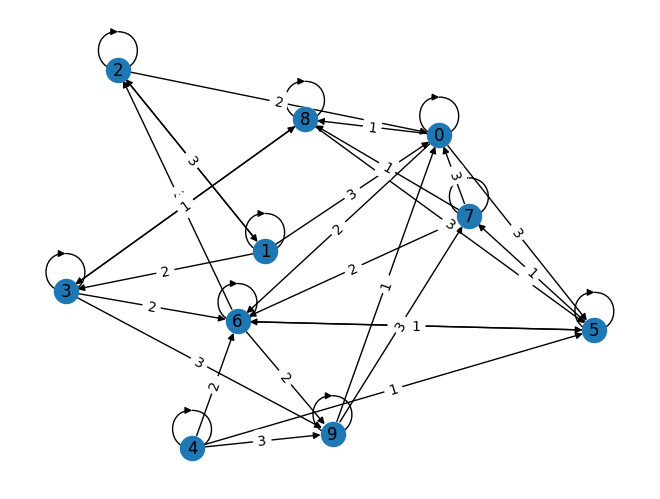

In [167]:
### Grab the five policies with the highest and lowest probabilities of being random
import networkx as nx

if fixed:
    # Generate a graph of the first MDP
    G = nx.DiGraph()
    for i in range(NUM_STATES):
        G.add_node(i)
    enumerated_edges = {}
    for i in range(NUM_ACTIONS):
        enumerated_edges[i] = []
        for j in range(NUM_STATES):
            for k in range(NUM_STATES):
                if MDPS[0].P[i][j, k] == 1:
                    G.add_edge(j, k, action = i)
                    enumerated_edges[i].append((j, k))
    edge_labels = {(u, v): f"{d['action']}" for u, v, d in G.edges(data=True)}
    pos = nx.spring_layout(G, k=0.5, iterations=20)  # k: Optimal distance between nodes. Increase/decrease to spread nodes out
    nx.draw(G, pos = pos, with_labels = True)
    nx.draw_networkx_edge_labels(G, pos = pos, edge_labels = edge_labels)
    
    for i in range(NUM_ACTIONS):
        print(f"Action {i} transitions:", enumerated_edges[i])

highest_probs = np.argsort(y_pred[:, 1])[-5:]
lowest_probs = np.argsort(y_pred[:, 1])[:5]
#print("Highest probabilities:", [(y_pred[i], y_test[i]) for i in highest_probs])
for i in np.concatenate((highest_probs, lowest_probs)):
    print("Policy:", policies[i], "Probability:", y_pred[i], "Actual:", y_test[i])

- On a random deterministic MDP(s), it doesn't seem like URS is identifiable, which is perhaps to be expected as every policy is optimal for some (normalized) reward function
    - This also matches our results when looking at the distribution of optimal policies for "cloud"-y MDPs
- Apparently my neural networks aren't predicting very well
- With MDPs with loops, logistic regression achieves ~0.70 accuracy; neural network does slightly better than random?
    - Although the NN's accuracy is basically 0.5
    - This holds true when we use the label predictions for regression (model.predict), as well as the probability prediction (model.predict_proba)
- Distance to loop correlates somewhat well with P(URS) (~0.64 accuracy), length of loop not as well
